In [56]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.autograd import Variable
import torchvision
import os
import random
from sklearn.metrics import normalized_mutual_info_score

In [57]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import matplotlib.pyplot as plt # data visualization library
import sklearn
from sklearn.datasets import fetch_olivetti_faces

# Exercise : Convolution Neural Network

In [58]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [59]:
# Download data and define the transformer (data normalization)
# Do not change this function
def load_data(seed_value=42):
    MNIST_normalize = transforms.Normalize((0.1307,), (0.3081,))
    MNIST_transform = transforms.Compose([
      transforms.ToTensor(),
      MNIST_normalize
    ])

    # MNIST Dataset
    train = datasets.MNIST(root='./data/',
                                train=True,
                                transform=MNIST_transform,
                                download=True)

    test = datasets.MNIST(root='./data/',
                                train=False,
                                transform=MNIST_transform)

    #print(valid.dataset.data.shape)
    train_subset_size = 5000
    train.data = train.data[0:train_subset_size]
    train.targets = train.targets[0:train_subset_size]

    train_size = int(0.9 * train_subset_size)
    val_size =  int(0.1 * train_subset_size)
    print("train_set_size:", train_size)
    print("val_set_size:", val_size)

    train, valid = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(seed_value))

    return train, valid, test

In [60]:
# Function to show data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [61]:
# Data Loader 
def get_data_loaders(dataset, batch_size, shuffle=True):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle)
    return loader

In [62]:
# Model
class Conv_Net(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.drop = nn.Dropout(dropout_value)
        self.fc = nn.Linear(6400, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.drop(x)
        x = self.fc(x)
        return F.log_softmax(x)

In [63]:
# Run one training epoch
def train(epoch, train_loader, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [64]:
# Compute metrics
def test(test_loader, device, is_train_set=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).data
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        'Train evaluation' if is_train_set else 'Val/Test evaluation', test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [65]:
# Use the default seed
seed_everything(seed=42)

# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.0
dropout_value = 0.0
num_epochs = 15

# Select the device
# device = 'cuda'
device = 'cpu'

# Define the network
model = Conv_Net(dropout_value).to(device)

# Define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

# Divide the available data into training and validation datasets
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)

# Run the training epochs
for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)

# Compute the metrics using the testing dataset
test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500
Train Epoch: 1 [0/4500 (0%)]	Loss: 2.338832


C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\1825828453.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/4500 (28%)]	Loss: 3.472323
Train Epoch: 1 [2560/4500 (56%)]	Loss: 1.623172
Train Epoch: 1 [3840/4500 (83%)]	Loss: 0.983392


c:\Users\mingy\OneDrive\Documents\anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Train evaluation: Average loss: 0.4742, Accuracy: 3901/4500 (87%)


Val/Test evaluation: Average loss: 0.5751, Accuracy: 420/500 (84%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.411350
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.436917
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.459639
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.276444

Train evaluation: Average loss: 0.3300, Accuracy: 4115/4500 (91%)


Val/Test evaluation: Average loss: 0.4669, Accuracy: 436/500 (87%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.428256
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.307650
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.058620
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.310271

Train evaluation: Average loss: 0.1830, Accuracy: 4265/4500 (95%)


Val/Test evaluation: Average loss: 0.2955, Accuracy: 460/500 (92%)

Train Epoch: 4 [0/4500 (0%)]	Loss: 0.250310
Train Epoch: 4 [1280/4500 (28%)]	Loss: 0.207581
Train Epoch: 4 [2560/4500 (56%)]	Loss: 0.337184
Train Epoch: 4 [3840/4500 (83%)]	Loss: 0.187362

Train evaluation: Averag

In [66]:
seed_everything(seed=42)
# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.0
dropout_value = 0.5
num_epochs = 15

# device = 'cuda'
device = 'cpu'

# define the network
model = Conv_Net(dropout_value).to(device)

# define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

#divide data to train and val
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)


for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)


test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500
Train Epoch: 1 [0/4500 (0%)]	Loss: 2.387906


C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\1825828453.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/4500 (28%)]	Loss: 1.876028
Train Epoch: 1 [2560/4500 (56%)]	Loss: 1.045734
Train Epoch: 1 [3840/4500 (83%)]	Loss: 1.068790

Train evaluation: Average loss: 0.9100, Accuracy: 3581/4500 (80%)


Val/Test evaluation: Average loss: 0.9994, Accuracy: 386/500 (77%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 1.148326
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.773733
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.558351
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.390689

Train evaluation: Average loss: 0.2433, Accuracy: 4195/4500 (93%)


Val/Test evaluation: Average loss: 0.2471, Accuracy: 463/500 (93%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.534245
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.354335
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.428390
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.450783

Train evaluation: Average loss: 0.1522, Accuracy: 4288/4500 (95%)


Val/Test evaluation: Average loss: 0.1598, Accuracy: 466/500 (93%)

Train Epoch: 4 [0/4500 (0%)]	Loss: 0.386017
Train Epoch: 4 [1280/4500

In [67]:
seed_everything(seed=42)
# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.05
dropout_value = 0.0
num_epochs = 15
# device = 'cuda'
device = 'cpu'

# define the network
model = Conv_Net(dropout_value).to(device)

# define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

#divide data to train and val
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)


for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)


test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500
Train Epoch: 1 [0/4500 (0%)]	Loss: 2.338832


C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\1825828453.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/4500 (28%)]	Loss: 3.334438
Train Epoch: 1 [2560/4500 (56%)]	Loss: 1.474590
Train Epoch: 1 [3840/4500 (83%)]	Loss: 1.019231

Train evaluation: Average loss: 0.4045, Accuracy: 3926/4500 (87%)


Val/Test evaluation: Average loss: 0.4613, Accuracy: 426/500 (85%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.353475
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.327830
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.433381
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.271496

Train evaluation: Average loss: 0.3152, Accuracy: 4083/4500 (91%)


Val/Test evaluation: Average loss: 0.3484, Accuracy: 446/500 (89%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.270919
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.386506
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.264114
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.255195

Train evaluation: Average loss: 0.3584, Accuracy: 4001/4500 (89%)


Val/Test evaluation: Average loss: 0.4447, Accuracy: 424/500 (85%)

Train Epoch: 4 [0/4500 (0%)]	Loss: 0.319754
Train Epoch: 4 [1280/4500

# Exercise : MF Faces

In [68]:
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Definition of the data matrix:

In [69]:
D = faces.data

The observations/rows pf the data matrix can be visualized as pictures. 10 consecutive pictures are taken from one person. This are the first 30 pictutres.

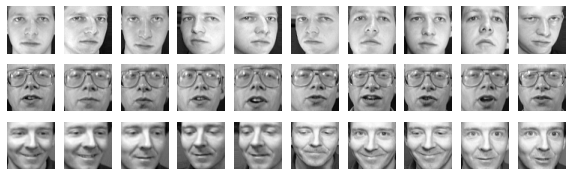

In [70]:
# Here are the first ten guys of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(D[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [71]:
from sklearn.decomposition import TruncatedSVD


In [72]:
mu_F = np.mean(D, axis=0)
def PCA(D, r, reconstruct = True, component=False):
    # center values
    C = D - mu_F.T
    # initiate trucated svd
    svd = TruncatedSVD(n_components=r)    
    Y_new = svd.fit_transform(C)

    
    Xt = svd.components_
    print((C@Xt.T).shape)
    
    if component:
        return Xt
    
    # if reconstruction, provide it
    if reconstruct:
        P = C @ Xt.T        
        return (P@Xt).T + mu_F.T.reshape(4096, 1)
    
    # return pca 
    return C@Xt.T


(400, 4)


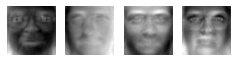

In [73]:
# question 2 a
Xt_result = PCA(D, 4, component=True)
fig = plt.figure(figsize=(4, 1))
for i in range(4):
    ax = plt.subplot2grid((1, 4), (int(i/4), i-int(i/4)*4))
    ax.imshow(Xt_result[i].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [74]:
#quetsion 2b
y_result = PCA(D, 5, reconstruct= False)
print(y_result[0])

(400, 5)
[-6.432611  -0.7036756 -1.4300231  1.2785162  2.5643153]


(400, 25)
(400, 50)
(400, 100)


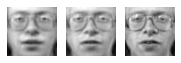

In [75]:
#quetsion 2c
twentyfive = PCA(D, 25)
fifty = PCA(D, 50)
hundred = PCA(D, 100)
resconstruct_fig = [twentyfive[:,19] , fifty[:,19] , hundred[:,19]]
fig = plt.figure(figsize=(3, 1))
for i in range(3):
    ax = plt.subplot2grid((1, 3), (int(i/3), i-int(i/3)*3))
    ax.imshow(resconstruct_fig[i].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

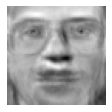

In [76]:
# question 2d
C = D - mu_F.T
P = -np.ones((400,50))
svd = TruncatedSVD(n_components=50) 
Y_new = svd.fit_transform(C)   
Xt = svd.components_
generate =  (P@Xt).T + mu_F.T.reshape(4096, 1)


for i in range(1):
    ax = plt.subplot2grid((1, 3), (int(i/3), i-int(i/3)*3))
    ax.imshow(generate[:,i].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')



# Exercise: k-means Initialization

In [77]:
!pip3 show scikit-learn

In [78]:
!pip3 show numpy

If your versions don't match, the following commands (or their anaconda version) could help to get the newest stable release. If you need help with this, please ask the TAs during instruction hours.

In [79]:
!pip3 install scikit-learn --upgrade
!pip3 install numpy --upgrade

The functions generating the datasets are given here:

In [80]:
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 2.5, epsilon + 0.5])
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [81]:
def get_dist(i, D, X,s):
    """
    Calculate minimal distance
    """
    return min((D[i, :].T - X[s])**2)

def get_prob(i,D,X,s):
    """
    Generate probability distribution
     with distance measure
    """
    return get_dist(i,D, X,s) / sum([get_dist(j,D,X,s) for j in range(n)])


In [82]:
def dist(v,X):
    distance=100000
    for i in range(X.shape[1]):
        if distance>np.linalg.norm(X[:,i]-v):
            distance=np.linalg.norm(X[:,i]-v)
    return distance

In [83]:
def init_centroids_greedy_pp(D,r,l=10):
    global n
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    list_i=rng.integers(low=0, high=n, size=l)
    value=100000
    flag=0
    for i in list_i:
        element=np.tile(D[i],(D.shape[0],1))
        current=np.sum(np.linalg.norm(D-element,axis=1))

        if value>current:
            value=current
            flag=i

        X=D[flag]
        X=np.expand_dims(X,axis=0)
        X = np.transpose(X)#(2,1)

    s=2

    while s<=r:
        # list_i=np.array([i in range(n)])
        sum_distance = sum([dist(D[i],X) for i in range(n)])

        p=[dist(D[i],X)/sum_distance for i in range(n)]
        list_i=rng.choice(np.arange(500), p=p, size=l)

        value = 100000
        flag = 0
        for i in list_i:
            element = np.concatenate((X,np.transpose(np.expand_dims(D[i],axis=0))),axis=1)#need test!!!
            current = sum([dist(D[j] , element) for j in range(n) ])

            if value > current:
                value = current
                flag = i
        print(flag)
        X=np.concatenate((X,np.transpose(np.expand_dims(D[flag],axis=0))),axis=1)
        s=s+1

    return X

In [84]:
import scipy
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")
    A = V[:,1:]
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)
    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [85]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

In [86]:
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

We generate a dataset.

In [87]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)


Run kmeans and spectral clustering based on the initialization technique.

In [88]:
# X_init = init_centroids_greedy_pp(D,r,l=10)
l_list = [15,25,30,35]
for i in l_list:
    X_init = init_centroids_greedy_pp(D,r,l=i)
    X,Y = kmeans(D,r, X_init)
    y = np.where(Y==1)
    print(normalized_mutual_info_score(y[1],labels))



494
115
6 iterations
0.6673160897543996
494
401
6 iterations
0.6673160897543996
414
323
6 iterations
0.6673160897543996
414
91
6 iterations
0.6673160897543996


Plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

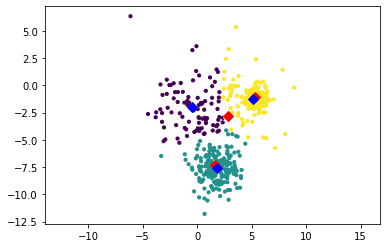

In [89]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [90]:
dataID, D, labels, r = generateMoons(0.05,n)

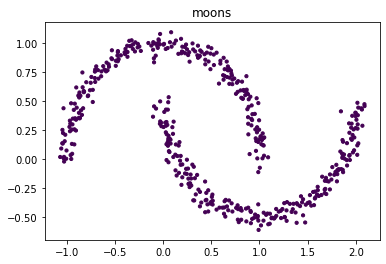

In [91]:
from sklearn.neighbors import NearestNeighbors as nn
knn = nn(n_neighbors=25).fit(D)
dis , clustering  = knn.kneighbors(D)
plt.scatter(D[:, 0], D[:, 1], c=np.argmax(dis,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()



222
6 iterations


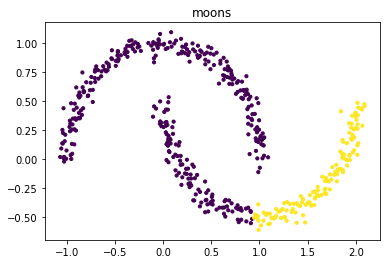

In [92]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
W = radius_neighbors_graph(D,0.5,include_self=False)
Y = spectral_clustering(W,r,init_centroids_greedy_pp)
plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()


# Exercise : Movielens
To read the dataset you might need to alter the path to look for it:

In [93]:
# lets explore movies.csv
movies= pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [94]:
# lets explore ratings.CSV
ratings=pd.read_csv('ratings.csv',sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The original ratings are in the range of 0.5 and 5:

In [95]:
min(ratings["rating"]), max(ratings["rating"])

(0.5, 5.0)

We convert the sparse representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [96]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We consider here only the movies which have been rated by more than 200 users. That are 18 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the prnciple and do not need a big dataset.

In [97]:
np.sum(np.sum(df_movie_ratings!=0,0)>200)

18

In [98]:
keep_movie = np.sum(df_movie_ratings!=0,0)>200
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Furthermore, we will throw out all the users which have not rated more than five movies.

In [99]:
np.sum(np.sum(df_D!=0,1)>5)

344

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [100]:
keep_user = np.sum(df_D!=0,1)>5
df_D = df_D.loc[keep_user,:]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,1.0,5.0,4.0,0.0,2.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0
7,4.5,0.0,4.5,0.0,4.5,5.0,0.0,0.0,5.0,5.0,0.0,2.5,5.0,4.5,4.0,0.0,4.0,0.0


The movie number- title assignments are given as follows:

In [101]:
movies.loc[movies['movieId'].isin(df_D.columns)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


The resulting data matrix is given as follows:

In [102]:
D = df_D.to_numpy()
D.shape

(344, 18)

Open question

In [103]:
import random
import copy

In [104]:
def init_random(n, d, r):
    """
    X <- Choose initial cluster centroids randomly
    Y <- Choose random cluster assignment
    """
    X = np.random.rand(d, r)*5
    Y = np.zeros((n, r), dtype=np.int64)
    for i, _ in enumerate(Y):
        Y[i][random.randrange(5)] = 1

    return X, Y


def indicator_nonzero(D):
    """
    Binary matrix to indicate observed values
    """
    O = D.copy()
    O[O > 0] = 1
    return O


def MSEO(D, O, X, Y):
    """
    Mean squared error of observed observations
    """
    seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
    return np.nanmean(seo)


def matrixcompletion(D, r, t_max = 100, l = 0.00001, use_stopping: bool = True):
    mseo_list = list()
    n, d = D.shape
    X, Y = init_random(n, d, r)
    O = indicator_nonzero(D)
    t = 1
    
    while t < t_max+1:
        new_X = X
        new_Y = Y
        
        for k in range(0, d):
            O_x_k = np.zeros((n, n))
            np.fill_diagonal(O_x_k, O[:, k])
            inv_imp = np.linalg.inv(
                            np.transpose(Y).dot(O_x_k).dot(Y) + l*np.identity(r)
                        )
            new_X[k] = np.transpose(D[:, k]).dot(Y).dot(inv_imp)
            
        for i in range(0, n):
            O_y_i = np.zeros((d, d))
            np.fill_diagonal(O_y_i, O[i, :])
            inv_y_imp = np.linalg.inv(
                            np.transpose(X).dot(O_y_i).dot(X) + l*np.identity(r)
                        )
            new_Y[i] = D[i, :].dot(X).dot(inv_y_imp)
        
        mseo_cal = MSEO(D, O, new_X, new_Y)
        
        # stopping criterion for l = 0.00001
        if l == 0.00001 and use_stopping:
            if len(mseo_list) > 10 and min(mseo_list) < 5 and \
                mseo_cal < 5 and mseo_cal > mseo_list[-1]:
                return X, Y, mseo_list
        
        mseo_list.append(mseo_cal)
        
        X, Y = new_X, new_Y
            
        t+=1
    
    return X, Y, mseo_list
    

5a

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Final mseo: 17.057260569017377
Number of iterations 100


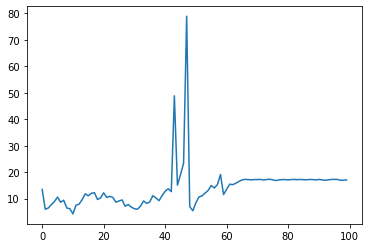

In [114]:

X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5, use_stopping=False)
plt.plot(mseo_list)

print("Final mseo:", mseo_list[-1])
print("Number of iterations", len(mseo_list))

5c

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Final mseo: 2.6036422997559896
Number of iterations 70


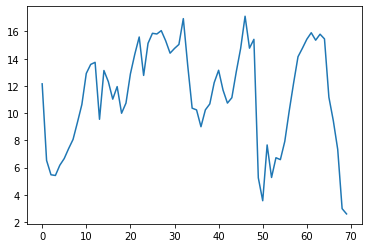

In [120]:
X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5)
plt.plot(mseo_list)

print("Final mseo:", mseo_list[-1])

print("Number of iterations", len(mseo_list))

5d

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Last MSEO: 16.440805438730997


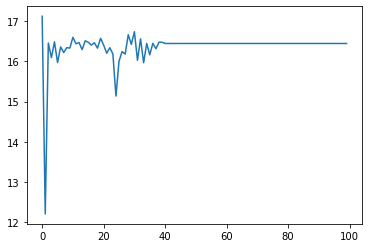

In [107]:
X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5, l=1)
print("Last MSEO:", mseo_list[-1])

plt.plot(mseo_list)

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Last MSEO: 15.138009287995612


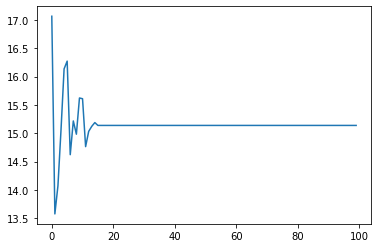

In [108]:
X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5, l=0.5)
print("Last MSEO:", mseo_list[-1])
plt.plot(mseo_list)

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Last MSEO: 16.565767908579254


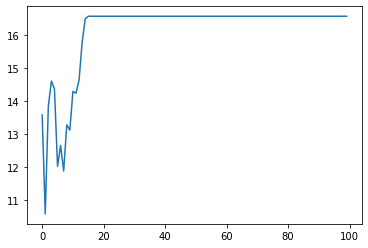

In [109]:
X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5, l=0.1)
print("Last MSEO:", mseo_list[-1])
plt.plot(mseo_list)

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Last MSEO: 17.056280173994324


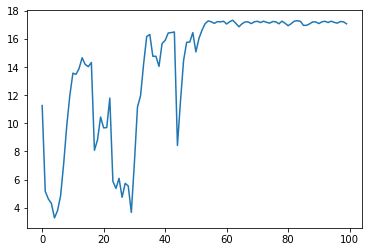

In [110]:
X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5, l=0.0001)
print("Last MSEO:", mseo_list[-1])
plt.plot(mseo_list)

C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: divide by zero encountered in true_divide
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)
C:\Users\mingy\AppData\Local\Temp\ipykernel_3624\2805318815.py:27: RuntimeWarning: invalid value encountered in multiply
  seo = np.multiply(1/abs(O), (D - np.multiply(O,(Y.dot(np.transpose(X)))))**2)


Last MSEO: 3.2203424687495192


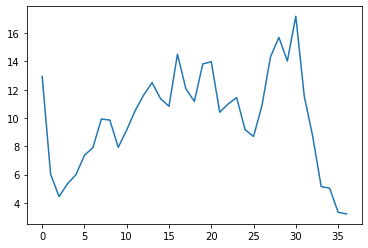

In [111]:
X, Y, mseo_list = matrixcompletion(D, t_max=100, r=5, l=0.00001)
print("Last MSEO:", mseo_list[-1])
plt.plot(mseo_list)